## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [3]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [4]:
fake.shape

(23481, 4)

In [5]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [6]:
# Add flag to track fake and real
fake['target'] = 'fake'
true['target'] = 'true'

In [7]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [8]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [9]:
# Check the data
data.head()

,title,text,subject,date,target
0,U.S. urges Myanmar to address rights abuse all...,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,"September 19, 2017",true
1,FORD CEO Tells Trump They’ll Move Forward With...,Perhaps the focus should be on the EPA and oth...,politics,"Mar 28, 2016",fake
2,Funding battle begins with House bill on regul...,WASHINGTON (Reuters) - The first shots in a po...,politicsNews,"May 25, 2016",true
3,NY state reaches deal to raise minimum wage to...,"ALBANY, New York, (Reuters) - Governor Andrew...",politicsNews,"March 31, 2016",true
4,White House says it did not leak material used...,WASHINGTON (Reuters) - The White House said on...,politicsNews,"January 6, 2017",true


In [10]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,U.S. urges Myanmar to address rights abuse all...,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true
1,FORD CEO Tells Trump They’ll Move Forward With...,Perhaps the focus should be on the EPA and oth...,politics,fake
2,Funding battle begins with House bill on regul...,WASHINGTON (Reuters) - The first shots in a po...,politicsNews,true
3,NY state reaches deal to raise minimum wage to...,"ALBANY, New York, (Reuters) - Governor Andrew...",politicsNews,true
4,White House says it did not leak material used...,WASHINGTON (Reuters) - The White House said on...,politicsNews,true


In [11]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,WASHINGTON (Reuters) - U.S. Secretary of State...,worldnews,true
1,Perhaps the focus should be on the EPA and oth...,politics,fake
2,WASHINGTON (Reuters) - The first shots in a po...,politicsNews,true
3,"ALBANY, New York, (Reuters) - Governor Andrew...",politicsNews,true
4,WASHINGTON (Reuters) - The White House said on...,politicsNews,true


In [12]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,washington (reuters) - u.s. secretary of state...,worldnews,true
1,perhaps the focus should be on the epa and oth...,politics,fake
2,washington (reuters) - the first shots in a po...,politicsNews,true
3,"albany, new york, (reuters) - governor andrew...",politicsNews,true
4,washington (reuters) - the white house said on...,politicsNews,true


In [13]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [14]:
# Check
data.head()

,text,subject,target
0,washington reuters us secretary of state rex ...,worldnews,true
1,perhaps the focus should be on the epa and oth...,politics,fake
2,washington reuters the first shots in a polit...,politicsNews,true
3,albany new york reuters governor andrew cuom...,politicsNews,true
4,washington reuters the white house said on fr...,politicsNews,true


In [15]:
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rajan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
data.head()


,text,subject,target
0,washington reuters us secretary state rex till...,worldnews,true
1,perhaps focus epa government agencies create e...,politics,fake
2,washington reuters first shots political battl...,politicsNews,true
3,albany new york reuters governor andrew cuomo ...,politicsNews,true
4,washington reuters white house said friday mat...,politicsNews,true


## Data Exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


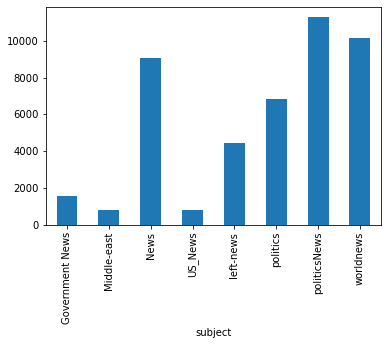

In [17]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
fake    23481
true    21417
Name: text, dtype: int64


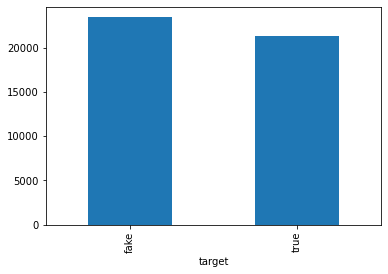

In [18]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="bar")
plt.show()

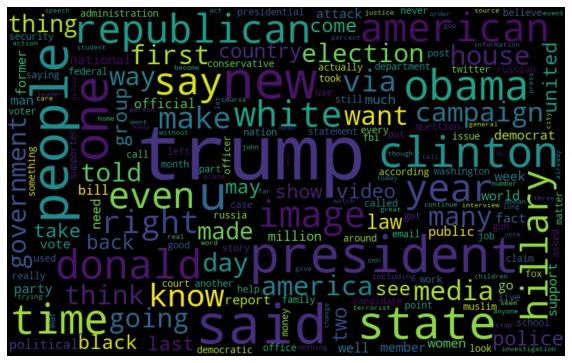

In [19]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

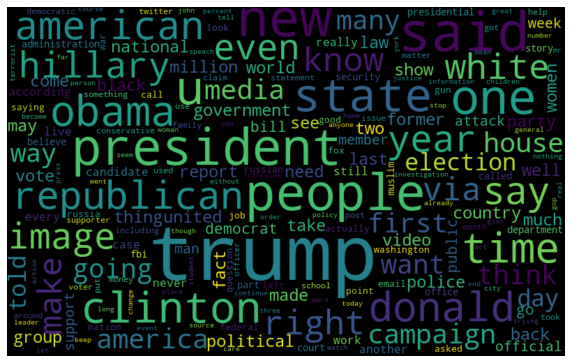

In [20]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [21]:
# Most frequent words counter (Code adapted from https://www.kaggle.com/rodolfoluna/fake-news-detector)   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

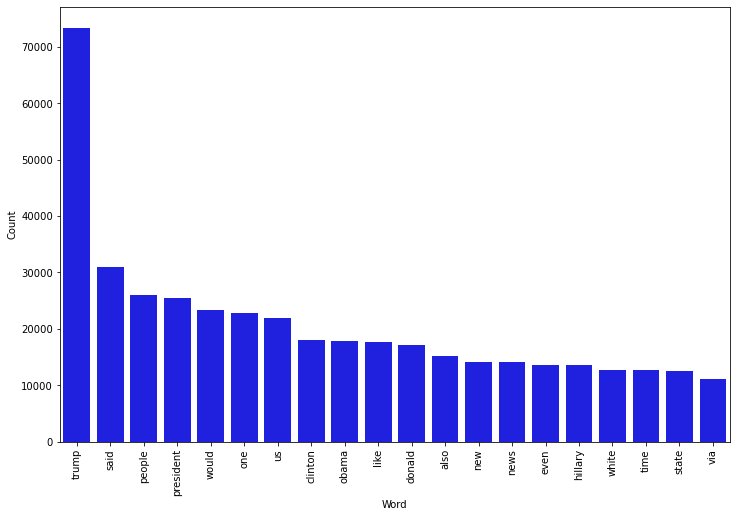

In [22]:
# Most frequent words in fake news
counter(data[data["target"] == "fake"], "text", 20)

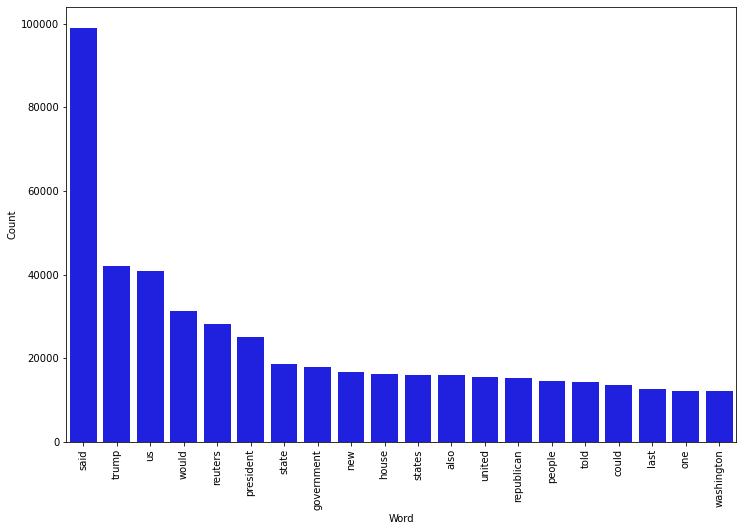

In [23]:
# Most frequent words in real news
counter(data[data["target"] == "true"], "text", 20)

## Modeling 

In [24]:
# Function to plot the confusion matrix (code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

## Logistic Regression 

In [26]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 98.99%


Confusion matrix, without normalization


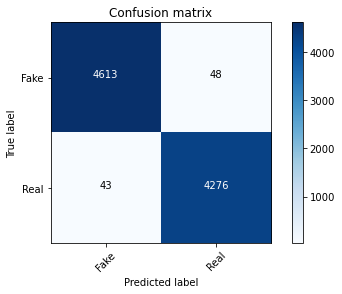

In [27]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])


## Decision Tree Classifier

In [28]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.64%


Confusion matrix, without normalization


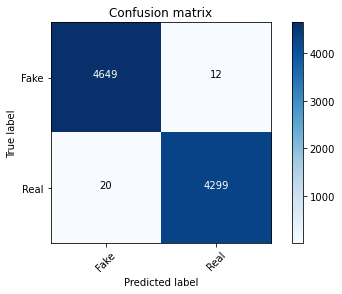

In [29]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## Random Forest Classifier

In [30]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

accuracy: 99.41%


Confusion matrix, without normalization


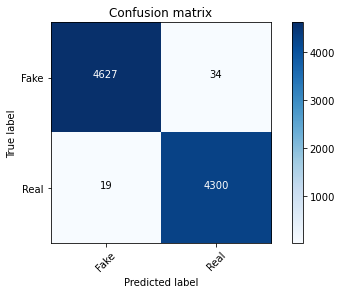

In [31]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])